# 张老师新给损失函数实现


## 加载各种包

In [2]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
# from sklearn.preprocessing import label_binarize
# from sklearn import preprocessing
# from sklearn import tree 

import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as scio
# import hiddenlayer as h
from visdom import Visdom
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from torchviz import make_dot

import datetime
import os 

import sys
# from utils.reuse import *
# from utils.networks import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 选择要加载的文件
步骤如下：
### 文件存储的路径解释
/data/rmgmf_0430/:存储着所有数据集，文件名末尾的数字表示数据量，例如EMGSKdata-220426-slim_400.npy 表示这是降采样到 400 数据点的数据集。
/src/model/: 存储所有模型相关的文件。
### 模型文件举例说明
`/src/model/emgmk_cnn_0410_nl/`为第一个模型的存储路径，对应数据集为 400 的数据；
此目录下有数个文件，一般是两个，按生成时间先后，早一点的是不带 new loss 的纯 MSE 损失模型，晚一点的是带 newloss 的模型。注意区分。
如果其他模型的文件夹内多于两个（如`emgmk_cnn_0410_nl_2`有3个），只看最新的两个文件，删除旧的，剩下的两个最新的同上区分方法。
`/src/model/emgmk_cnn_0410_nl/vislog/`: visdom 日志，暂时不需要处理；
`/src/model/emgmk_cnn_0410_nl/vislog/ckp/`:训练记录点，暂时不需要，我已经删除这一文件夹
### 加载与运行说明
1.加载数据与模型
下面的代码中，`dataarray = np.load('../data/emgmf_0430/EMGSKdata-220426-slim_400.npy',allow_pickle=True)`填入本次的数据集，
`checkpoint_for_net2 = torch.load('./model/emgmk_cnn_0410_nl/'+'kmmf_final__2022_04_30_21_34_48.pth')`填入本次的模型。
2.运行所有代码至最后一个代码块之前。
3.结果展示部分，修改`show_l`与测试集大小匹配，测试集大小可查看数据集加载部分代码块的第一行输出，例如`(480, 1) (120, 1)`，120就是要设成 `show_l`的数字
4.重复`column`0~5，每次记录输出的图的RMSE值，放到一个excel里，即`结果记录.xlsx`
4.在最后一个代码块`io.savemat('../data/data_400_mse.mat', {'variables': adataset_kmmf})`里设置本次的存储文件名称。记得对应数据集修改文件名。同时MSE的模型后面要标记_mse 以做区分
5.结束，后续绘图工作转至matlab进行


In [ ]:
dataarray = np.load('../data/emgmf_0430/EMGSKdata-220426-slim_400.npy',allow_pickle=True)
checkpoint_for_net2 = torch.load('./model/emgmk_cnn_0410_nl/'+'kmmf_final__2022_04_30_21_34_48.pth')

## 定义神经网络结构


In [3]:
# 自定义神经网络,CNN
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# hdreshape = 32*1*3
# hdreshape = 2
# hdlayer_1 = 16
# hdlayer_2 = 16
# hdlayer_3 = 256
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128,\
             kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,\
             kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, \
            kernel_size=3, padding=0)

        self.fc1 = nn.Linear(in_features=128*1*6, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        # self.fc3 = nn.Linear(in_features=hdlayer_2, out_features=hdlayer_3)
        self.out = nn.Linear(in_features=128, out_features=6)
        self.dr1 = nn.Dropout2d(0.2)

    def forward(self, t):
        # (1) input layer
        t = t
        # t = t.reshape(1,1,3)
        # t = t.unsqueeze(0)

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (3) hidden conv layer
        # t = self.conv2(t)
        # t = F.relu(t)
        # t = self.dr1(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (4) hidden linear layer
        t = t.reshape(-1, 128*1*6)
        # t = t.flatten(start_dim=0)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        # t = self.fc3(t)
        # t = F.relu(t)
        # t = self.dr1(t)

        # (5) output layer
        t = self.out(t)

        return t

net = Network()
# 打印网络，检查输入输出 shape是否正确
# print(net)
samplebatchsize = 1
summary(net,(1,1,6),batch_size = samplebatchsize,device = "cpu")
sampleInput = torch.randn(samplebatchsize,1,1,6).requires_grad_(True)
sampleOutput = net(sampleInput)
print('Outputshape:',sampleOutput.shape)
# framevision = make_dot(sampleOutput, params=dict(list(net.named_parameters()) + [('x',sampleInput)]))
# framevision.format = "png"
# framevision.direcory = "./"
# framevision.view()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 128, 1, 6]           1,280
            Linear-2                   [1, 128]          98,432
            Linear-3                   [1, 128]          16,512
            Linear-4                     [1, 6]             774
Total params: 116,998
Trainable params: 116,998
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.45
----------------------------------------------------------------
Outputshape: torch.Size([1, 6])


## 数据集加载、构建

In [19]:


CNNdataset = dataarray.item()
print(type(CNNdataset))
# 加载自变量：因为数据头尾不少空缺，裁剪之
data_head = 11
data_end = 2000
data_time = CNNdataset['time']#[data_head:data_end]
data_fcr= CNNdataset['fcr']#[data_head:data_end]
data_fcu = CNNdataset['fcu']#[data_head:data_end]
data_ecrl = CNNdataset['ecrl']#[data_head:data_end]
data_ecrb = CNNdataset['ecrb']#[data_head:data_end]
data_ecu = CNNdataset['ecu']#[data_head:data_end]
data_angle = CNNdataset['angle']#[data_head:data_end]
data_mf_fcr = CNNdataset['mf_fcr']#[data_head:data_end]
data_mf_fcu = CNNdataset['mf_fcu']#[data_head:data_end]
data_mf_ecrl = CNNdataset['mf_ecrl']#[data_head:data_end]
data_mf_ecrb = CNNdataset['mf_ecrb']#[data_head:data_end]
data_mf_ecu = CNNdataset['mf_ecu']#[data_head:data_end]
# 弧度转角度
data_angle = data_angle / (2 * np.pi) * 360

# data_time = CNNdataset['time'][data_head:data_end]
# data_fcr= CNNdataset['fcr'][data_head:data_end]
# data_fcu = CNNdataset['fcu'][data_head:data_end]
# data_ecrl = CNNdataset['ecrl'][data_head:data_end]
# data_ecrb = CNNdataset['ecrb'][data_head:data_end]
# data_ecu = CNNdataset['ecu'][data_head:data_end]
# data_angle = CNNdataset['angle'][data_head:data_end]
# data_mf_fcr = CNNdataset['mf_fcr'][data_head:data_end]
# data_mf_fcu = CNNdataset['mf_fcu'][data_head:data_end]
# data_mf_ecrl = CNNdataset['mf_ecrl'][data_head:data_end]
# data_mf_ecrb = CNNdataset['mf_ecrb'][data_head:data_end]
# data_mf_ecu = CNNdataset['mf_ecu'][data_head:data_end]
# data_angle = data_angle / (2 * np.pi) * 360
# 划分训练集与测试集，每5点抽取一点作为测试集
def DataSpliter(data):
    data_tr = []
    data_te = []
    for i in range(len(data)):
        if (i+1)%5 == 0:
            data_te.append(data[i,:])
        else:
            data_tr.append(data[i,:])
    data_tr = np.array(data_tr)
    data_te = np.array(data_te)
    return data_tr, data_te
# 自变量部分
tr_data_time,te_data_time = DataSpliter(data_time)
tr_data_fcr,te_data_fcr = DataSpliter(data_fcr)
tr_data_fcu,te_data_fcu = DataSpliter(data_fcu)
tr_data_ecrl,te_data_ecrl = DataSpliter(data_ecrl)
tr_data_ecrb,te_data_ecrb = DataSpliter(data_ecrb)
tr_data_ecu,te_data_ecu = DataSpliter(data_ecu)
# 因变量部分
tr_data_angle,te_data_angle = DataSpliter(data_angle)
tr_data_mf_fcr,te_data_mf_fcr = DataSpliter(data_mf_fcr)
tr_data_mf_fcu,te_data_mf_fcu = DataSpliter(data_mf_fcu)
tr_data_mf_ecrl,te_data_mf_ecrl = DataSpliter(data_mf_ecrl)
tr_data_mf_ecrb,te_data_mf_ecrb = DataSpliter(data_mf_ecrb)
tr_data_mf_ecu,te_data_mf_ecu = DataSpliter(data_mf_ecu)
print(tr_data_mf_ecu.shape,te_data_ecu.shape)
# 按需组合数据，这两函数其实可以合并成一个
def Data_conbine(data_1,data_2,data_3,data_4,data_5,data_6):
    data_train = []
    for i in range(len(data_1)):
        data_1t6 = np.hstack((data_1[i,:],data_2[i,:],data_3[i,:]\
            ,data_4[i,:],data_5[i,:],data_6[i,:]))
        data_1t6 = data_1t6.flatten()
        data_train.append(data_1t6)
    data_train = np.array(data_train)
    return data_train
def Data_conbine_5v(data_1,data_2,data_3,data_4,data_5):
    data_train = []
    for i in range(len(data_1)):
        data_1t6 = np.hstack((data_1[i,:],data_2[i,:],data_3[i,:]\
            ,data_4[i,:],data_5[i,:]))
        data_1t6 = data_1t6.flatten()
        data_train.append(data_1t6)
    data_train = np.array(data_train)
    return data_train
# 多时间步组建数据，这个在这里暂时没用上，因此我把它暂时注掉了
# def establish_multi_timestep_data(data_X,data_X_2,data_Y,expect_time_length):
#     dataset = []
#     dataset_y = []
#     if expect_time_length >0:
#         length = len(data_X)-expect_time_length
#         for i in range(length):
#             data_1 = data_X[i:i+expect_time_length,:]
#             data_1 = data_1.flatten()
#             data_2 = data_X_2[i:i+expect_time_length,:]
#             data_2 = data_2.flatten()
#             data_12 = np.hstack((data_1,data_2))
#             dataset.append(data_12)
#             dataset_y.append(data_Y[i+expect_time_length-1,:])
#         dataset = np.array(dataset)
#         dataset_y = np.array(dataset_y)
#     return dataset, dataset_y
# 将自变量与因变量各自组合到一起，尺寸均为1*6
data_1t6_tr = Data_conbine(tr_data_time,tr_data_fcr,tr_data_fcu\
    ,tr_data_ecrl,tr_data_ecrb,tr_data_ecu)
data_1t6_te = Data_conbine(te_data_time,te_data_fcr,te_data_fcu\
    ,te_data_ecrl,te_data_ecrb,te_data_ecu)
data_7t12_tr = Data_conbine(tr_data_angle,tr_data_mf_fcr,tr_data_mf_fcu\
    ,tr_data_mf_ecrl,tr_data_mf_ecrb,tr_data_mf_ecu)
data_7t12_te = Data_conbine(te_data_angle,te_data_mf_fcr,te_data_mf_fcu\
    ,te_data_mf_ecrl,te_data_mf_ecrb,te_data_mf_ecu)
data_8t12_tr = Data_conbine_5v(tr_data_mf_fcr,tr_data_mf_fcu\
    ,tr_data_mf_ecrl,tr_data_mf_ecrb,tr_data_mf_ecu)
data_8t12_te = Data_conbine_5v(te_data_mf_fcr,te_data_mf_fcu\
    ,te_data_mf_ecrl,te_data_mf_ecrb,te_data_mf_ecu)
# 转为 tensor 格式
data_1t6_tr = torch.from_numpy(data_1t6_tr).to(torch.float32)
data_1t6_te = torch.from_numpy(data_1t6_te).to(torch.float32)
data_7t12_tr = torch.from_numpy(data_7t12_tr).to(torch.float32)
data_7t12_te = torch.from_numpy(data_7t12_te).to(torch.float32)

print(data_1t6_tr.shape,data_7t12_tr.shape,data_1t6_te.shape,\
    data_7t12_te.shape)

# # 需要一个指示前一时刻的标签，居然没注意到 cyc 每五取一后不再连续了，害
data_index_tr = np.linspace(0,2000,2001)
data_index_te = np.linspace(0,2000,2000)

<class 'dict'>
(480, 1) (120, 1)
torch.Size([480, 6]) torch.Size([480, 6]) torch.Size([120, 6]) torch.Size([120, 6])


In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图片转换为Tensor,归一化至[0,1]
])
class EMGSK_Dataset(Dataset):
 
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y
        self.transforms = transform

    def __getitem__(self, index):
        sample_x = self.data_x[index,:]
        sample_y = self.data_y[index,:]
        # for CNN
        sample_x = sample_x.unsqueeze(0)
        sample_x = sample_x.numpy()
        sample_x = self.transforms(sample_x)
        # 一维数据用下面的这个就行
        # emgData = torch.Tensor(emgData)     
        return sample_x,sample_y
    
    def __len__(self):
        return len(self.data_x)

class EMGSK_nl_Dataset(Dataset):
 
    def __init__(self, data_x, data_y,data_idx):
        self.data_x = data_x
        self.data_y = data_y
        self.data_angle = self.data_y[:,0]
        self.data_time = self.data_x[:,0]
        self.data_mf = self.data_y[:,1:6]
        self.data_idx = data_idx
        self.transforms = transform

    def __getitem__(self, index):
        sample_x = self.data_x[index,:]
        sample_y = self.data_y[index,:]
        sample_mf = self.data_mf[index,:]
        sample_angle = self.data_angle[index]
        sample_time = self.data_time[index]
        sample_idx = self.data_idx[index]
        # for CNN
        sample_x = sample_x.unsqueeze(0)
        sample_x = sample_x.numpy()
        sample_x = self.transforms(sample_x)
        # 一维数据用下面的这个就行
        # emgData = torch.Tensor(emgData)     
        return sample_x,sample_y,sample_mf,sample_time,sample_angle,\
            sample_idx
    
    def __len__(self):
        return len(self.data_x)

train_set = EMGSK_nl_Dataset(data_1t6_tr,data_7t12_tr,\
    data_index_tr)
test_set = EMGSK_nl_Dataset(data_1t6_te,data_7t12_te,\
    data_index_te)

sample = iter(test_set)

print(sample)

## 结果展示
展示训练效果，保存模型文件等等

In [14]:

net2 = Network()
net2.load_state_dict(checkpoint_for_net2)
# net2.load_state_dict(checkpoint_for_net2['model'])
net2.eval()

Network(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=6, bias=True)
  (dr1): Dropout2d(p=0.2, inplace=False)
)

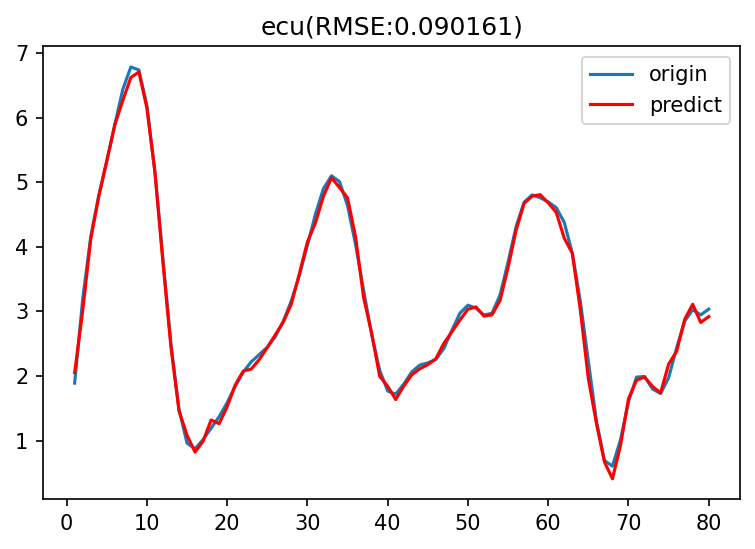

In [15]:

show_x = data_1t6_te
show_y = data_7t12_te
show_l = 80#397
column = 5
mf_namelist = ['angle','fcr','fcu','ecrl','ecrb','ecu']
# net3 = net
net = net2
net.eval()
net.to('cpu')
criterion = torch.nn.MSELoss()
# predict = net(show_x)
# predict = predict.data.numpy()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,shuffle=False)
predict_show = []
y_show = []
for batch in test_loader:
    s_x,s_y,s_mf,_,_,_= batch
    # s_y = s_mf
    predict = net(s_x) 
    pred2 = predict.detach().numpy()
    predict_show.append(pred2) 
    trainloss = criterion(predict, s_y)
    y_s = s_y.detach().numpy()
    y_show.append(y_s)
predict_show = np.array(predict_show)
y_show = np.array(y_show)
# MSE_show = criterion(torch.Tensor(predict_show[:,column]), torch.Tensor(y_show[:,column]))
MSE_show =  criterion(torch.Tensor(predict_show[:,:,column]), torch.Tensor(y_show[:,:,column]))
predict = predict.data.numpy()
# 建立等差数列，（起始，终止，个数）
x = np.linspace(1,show_l,show_l)
plt.rcParams['figure.dpi'] = 150
plt.title(mf_namelist[column]+'(RMSE:'+str('%.5g' % torch.sqrt(MSE_show))+')')
# plt.plot(x , show_y[:,column], label='origin')
plt.plot(x , show_y[:,column], label='origin')
# plt.plot(x, predict[:,column], color='red', label='predict')
plt.plot(x, predict_show[:,0,column], color='red', label='predict')
plt.legend()
plt.show()


In [17]:
from scipy import io
adataset_kmmf = {}
data_7t12_te = np.array(data_7t12_te)
adataset_kmmf['GT'] = data_7t12_te
adataset_kmmf['Preds'] = predict_show
io.savemat('../data/data_400_mse.mat', {'variables': adataset_kmmf})